In [5]:
%matplotlib inline


# Making Dynamic Decisions and the Bi-LSTM CRF


## 1. Bi-LSTM Conditional Random Field Discussion

### 1.1 Bi-LSTM-CRF的模型结构

回顾Bilstm-CRF的模型结构：

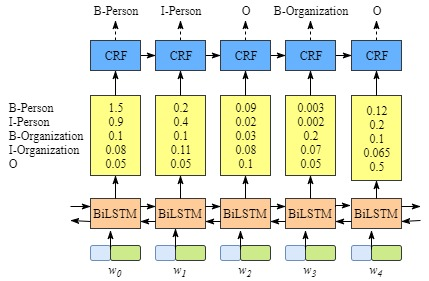

BiLSTM层的输出经过一个线性层为每一个标签的预测分值，然后将BiLSTM的输出值作为CRF层的输入，最后结果就是每个词的标签。

### 1.2 CRF的作用
 虽然BiLSTM就可以完成标注工作，但是没有办法添加约束条件，通过CRF层就可以添加标签之间的约束关系。

### 1.3 理解损失函数

回顾CRF计算概率的方式：
$y$是标签序列， $x$是一个输入的词序列.

计算：

\begin{align}P(y|x) = \frac{\exp{(\text{Score}(x, y)})}{\sum_{y'} \exp{(\text{Score}(x, y')})}\end{align}

这里，我们定义$Score(x,y)$分数为特征函数
$\log \psi_i(x,y)$， 有

\begin{align}\text{Score}(x,y) = \sum_i \log \psi_i(x,y)\end{align}

便于计算，我们只定义特征函数只有local特征（全局特征就升级为了NP-hard问题，复杂度太高）

在Bi-LSTM CRF的模型中, 我们定义两种特征输入: 发射概率（emission） 和转移概率
（transition）。 

每个词$w_i$的发射概率来自于第$i$步的LSTM层的隐状态。

转移概率存储在$|T|x|T|$ 矩阵中
$\textbf{P}$, 其中$T$是标签集合. 

在下面的代码实现中, $\textbf{P}_{j,k}$ 是从标签 $k$ 转移到标签 $j$ 的概率。

所以，对于输入序列 $x$ 对应的输出序列 $y$，定义分数为：

\begin{align}\text{Score}(x,y) = \sum_i \log \psi_\text{EMIT}(y_i \rightarrow x_i) + \log \psi_\text{TRANS}(y_{i-1} \rightarrow y_i)\end{align}

\begin{align}= \sum_i h_i[y_i] + \sum_{i=1}\textbf{P}_{y_i, y_{i-1}}\end{align}

更详细的关于CRF的公式推导可以参考
[这里](http://www.cs.columbia.edu/%7Emcollins/crf.pdf)



### 1.4 损失函数的计算细节

利用Softmax函数，我们为每一个正确的tag序列定义一个概率值（代表所有的tag序列，包括不可能出现的）

\begin{align} p(y|X)=\frac{e^{S(X,y)}}{\sum_{\tilde y \in Y_x} e^{S(X,\tilde y)}} \end{align}

因而在训练中，我们只需要最大化似然概率$p(y|X)$即可，这里我们利用对数似然

\begin{align} log（p(y|X)）=log(\frac{e^{S(X,y)}}{\sum_{\tilde y \in Y_x} e^{S(X,\tilde y)}}) \\ = S(X,y) - log \sum_{\tilde y \in Y_x} e^{S(X,\tilde y)}   \end{align}

所以我们将损失函数定义为$-log(p(y|X))$，就可以利用梯度下降法来进行网络的学习了。

在对损失函数进行计算的时候，$S(X,y)$的计算很简单，而$log(\sum_{\tilde y \in Y_x} e^{S(X,\tilde y)})$（下面记作logsumexp）的计算稍微复杂一些，因为需要计算每一条可能路径的分数。

这里用一种简便的方法，对于到词$w_i$的所有可能路径的分数的logsumexp（[什么是logsumexp?](https://en.wikipedia.org/wiki/LogSumExp)），可以先把到词$w_{i-1}$的logsumexp计算出来。

这里的推倒我在看了[知乎](https://zhuanlan.zhihu.com/p/27338210)和[csdn](https://blog.csdn.net/cuihuijun1hao/article/details/79405740)这两位博主的解释后，一头雾水，他们的博文里公式实在是写的前后不一致，定义极其模糊，理解全靠意会。我自己又重新推倒了一遍，现在记录下来。

假设输入的序列$x$的长度为$m$，我们知道计算 $S(x,y)$ 分数的时候，是从$i=1$时候开始累加每个$x_i, y_i$对应的分数，即公式(3)。

当$i=n (n<m)$时，有路径的得分分数

$$
\begin{align}\text{Score}(x[1:n], y) = \sum_{i=1}^n \log \psi_\text{EMIT}(y_i \rightarrow x_i) + \log \psi_\text{TRANS}(y_{i-1} \rightarrow y_i)\end{align}
$$

当$i=n+1$时，则路径的得分分数为

$$
\text{Score}(x[1:n+1], y) = \text{Score}(x[1:n], y)
$$$$
\begin{align} + \log \psi_\text{EMIT}(y_{n+1} \rightarrow x_{n+1}) + \log \psi_\text{TRANS}(y_{n} \rightarrow y_{n+1})\end{align}
$$

我们令$i=n+1$时，$y_{n+1}$的得分为K，也就是

$$
K= \log \psi_\text{EMIT}(y_{n+1} \rightarrow x_{n+1}) + \log \psi_\text{TRANS}(y_{n} \rightarrow y_{n+1}) 
$$

我们要计算的$i=n+1$时的loss的第一项为：

$$
log \sum_{\tilde y \in Y_x} e^{S(X[1:n+1],\tilde y)} 
= log \sum_{\tilde y \in Y_x} e^{\text{Score}(x[1:n], \tilde y) + K} \\
= log \sum_{\tilde y \in Y_x} e^{\text{Score}(x[1:n], \tilde y) } \cdot e^K \\
=  log \sum_{\tilde y \in Y_x} e^{\text{Score}(x[1:n], \tilde y) } + loge^K \\
= log \sum_{\tilde y \in Y_x} e^{\text{Score}(x[1:n], \tilde y) }  + K
$$

因此我们可以得到这样的结论：

> 当$i=n+1$时，序列$x_1,x_2, ..., x_n, x_{n+1}$对应的所有可能的标签路径的分数的
> logsumexp，等于序列$x_1,x_2, ..., x_n$对应的所有可能的标签路径的分数的
> logsumexp加上$x_{n+1}, y_{n+1}$的特征分数。

这一步是实现求loss函数的关键。这样的转化操作，可以让我们使用动态规划算法来计算所有可能路径分数的logsumexp。

### 1.5 维特比算法回顾

为了找出S到E之间的最短路径，我们先从S开始从左到右一列一列地来看。

首先起点是S，从S到A列的路径有三种可能：S-A1、S-A2、S-A3，如下图：
![viterbi_1.jpg](./image/viterbi_1.jpg)

我们不能武断地说S-A1、S-A2、S-A3中的哪一段必定是全局最短路径中的一部分，目前为止任何一段都有可能是全局最短路径的备选项。

我们继续往右看，到了B列。按B列的B1、B2、B3逐个分析。

![](./image/viterbi_2.jpg)

先看B1：
经过B1的所有路径只有3条：
 - S-A1-B1
 - S-A2-B1
 - S-A3-B1
 
以上这三条路径，各节点距离加起来对比一下，我们就可以知道其中哪一条是最短的。

假设S-A3-B1是最短的，那么我们就知道了经过B1的所有路径当中S-A3-B1是最短的，我们只保留这一条路径。
![](./image/viterbi_3.jpg)

接下来，我们继续看B2：
![](./image/viterbi_4.jpg)
同理，如上图，经过B2的路径有3条：
 - S-A1-B2
 - S-A2-B2
 - S-A3-B2

这三条路径中，各节点距离加起来对比一下，我们肯定也可以知道其中哪一条是最短的。

假设S-A1-B2是最短的，那么我们就知道了经过B2的所有路径当中S-A1-B2是最短的，我们只保留这一条路径。
![](./image/viterbi_5.jpg)
接下来我们继续看B3：
![](./image/viterbi_6.jpg)
同理，如上图，经过B3的路径也有3条：
- S-A1-B3
- S-A2-B3
- S-A3-B3
这三条路径中我们也肯定可以算出其中哪一条是最短的，假设S-A2-B3是最短的，那么我们就知道了经过B3的所有路径当中S-A2-B3是最短的，我们只保留这一条路径。
![](./image/viterbi_7.jpg)

现在对于B列的所有节点我们都过了一遍，B列的每个节点我们都删除了一些不可能是答案的路径，看看我们把剩下的备选的最短路径汇总，就是这张图。
![](./image/viterbi_8.jpg)
S-A3-B1、S-A1-B2、S-A2-B3都有可能是全局的最短路径的备选路径，我们还没有足够的信息判断哪一条一定是全局最短路径的子路径。

所以我们继续往后看C列。

![](./image/viterbi_9.jpg)

和B列的做法一样，我们分别找出C1、C2、C3的最优路径的备选路径并保存下来，最后到E的时候，我们只需要把到达C列的得分和C列分别到E的三条路径相加比较一下，就能得到最优路径了。

![](./image/viterbi_10.jpg)



## 2. Implementation Notes

The example below implements the forward algorithm in log space to
compute the partition function, and the viterbi algorithm to decode.
Backpropagation will compute the gradients automatically for us. We
don't have to do anything by hand.

The implementation is not optimized. If you understand what is going on,
you'll probably quickly see that iterating over the next tag in the
forward algorithm could probably be done in one big operation. I wanted
to code to be more readable. If you want to make the relevant change,
you could probably use this tagger for real tasks.

In [1]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

Helper functions to make the code more readable.



In [2]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

# 把seq转化为tensor的形式
def prepare_sequence(seq, to_ix):
    # seq是分词后语料，to_ix是语料库每个词对应的编号
    # step 1: 先转化为id的形式
    idxs = [to_ix[w] for w in seq]
    # step2: 再把id转化为tensor
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

创建模型

loss函数：\begin{align} -log（p(y|X)）=  \sum_{\tilde y \in Y_x} e^{S(X,\tilde y)} - S(X,y)   \end{align}

其中，``_forward_alg``计算loss的第一项（概率的分母）

``_score_sentence``计算loss的第二项（概率的分子）



In [3]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        '''
        初始化模型
        parameters：
            vocab_size：词的字典的大小
            tag_to_ix：标签与对应编号的字典
            embedding_dim：词向量维度
            hidden_dim：LSTM的个数
      '''
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        # 输入层，vocab_size*embedding_dim大小的矩阵
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM层
        # input_size：embedding_dim，输入维度
        # hiden_size: hidden_dim // 2, 每一层lstm有多少个特征抽取器，也就是多少个LSTM单元
        # num_layers: Number of recurrent layers. 
        #       E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, 
        #       with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
        # bidirectional: 是否是双向LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # 将LSTM的输出映射到标签空间，也就是0-1的范围内.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # 转移矩阵，Matrix of transition parameters.  Entry i,j is the score of
        # transitioning  *from* j *to* i
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # 定义强制性约束： 
        # 任何状态都不能转移到开始状态，结束状态不能转移到其它任何状态。
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    # 计算loss的第一项（分母项），也就是需要计算所有路径的总分数的log
    def _forward_alg(self, feats):
        
        #feats表示发射矩阵(emit score)，实际上就是LSTM的输出，意思是经过LSTM的sentence的每个word对应于每个label的得分
        
        # Do the forward algorithm to compute the partition function（）
        
        # 用-10000.来填充一个形状为[1,tagset_size]的tensor
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        
        # 因为start tag是4，所以tensor([[-10000., -10000., -10000., 0., -10000.]])，
        # 将start的值设零，表示开始进行网络的传播，
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas  # 初始状态的forward_var，随着step t变化

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                # LSTM的生成矩阵是emit_score，维度为1*5
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                
                # 对于到词$w_i$的路径，以先把到词$w_{i-1}$的logsumexp计算出来，再加上当前tag产生的分数
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            
            forward_var = torch.cat(alphas_t).view(1, -1)
            
        # 最后还需要加上最后一个词转移到结束位置的概率
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    # 计算 LSTM 发射概率
    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    # 计算一条路径对应的分数，也就是loss的第二项
    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        
        # 将START_TAG的id拼接到tag序列最前面
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            # self.transitions[tags[i + 1], tags[i]] 实际得到的是从标签i到标签i+1的转移概率
            # feat[tags[i+1]], feat是step i 的输出结果，有5个值，
            # 对应B, I, E, START_TAG, END_TAG, 取对应标签的值
            # transition【j,i】 就是从i ->j 的转移概率值
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
            
        # 分数最后还要加上最后一个词转移到STOP_TAG的转移概率
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        # 预测序列的得分，维特比解码，输出得分与路径值
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.) # 保证了一定是从START到其他标签
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]  #forward_var保存的是之前的最优路径的值
                best_tag_id = argmax(next_tag_var) #返回最大值对应的那个tag的id
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        # 从最后一步的best_path的选择，根据backpointers倒推整个的best_path
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    # 计算loss，训练时候用
    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    # 计算一个句子的分数和最优的标注序列，预测时候用
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

Run training



In [4]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5 
HIDDEN_DIM = 4 # 这其实是BiLSTM的隐藏层的特征数量，因为是双向所以是2倍，单向为2

# Make up some training data
training_data = [(
    "the wall street journal reported today that apple corporation made money".split(),
    "B I I I O O O B I O O".split()
), (
    "georgia tech is a university in georgia".split(),
    "B I O O O O B".split()
)]

# 构造训练数据中的word_to_ix的映射关系，给每一个词对应一个唯一的编码
# 比如‘HELLO WORLD’就是{'HELLO':0,'WORLD:1'}
word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

    
# 构造tag_to_ix词典，每一个tag有一个唯一的编码
tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}

# 模型
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
    print(model(precheck_sent))

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(
        300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. 一定要记住Pytorch会累积梯度
        # 所以我们在每个样本训练之前需要清除梯度
        model.zero_grad()

        # Step 2. 准备模型的输入，把输入的样本数据转化为模型需要的格式
        # 把输入的词序列和标签转化为id，再把id转化为Tensor
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. 让模型前向传播计算Loss
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. 反向传播计算梯度，用optimizer.step()来更新参数
        loss.backward()
        optimizer.step()

# Check predictions after training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    print(model(precheck_sent))
# We got it!

(tensor(2.6907), [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
(tensor(20.4906), [0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2])
